In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

from src.helpers import (
    get_data,
    plot_prices, 
    plot_prices_over_time, 
    plot_regression_lines
)

register_matplotlib_converters()
plt.style.use('seaborn-poster')

### Data

In [2]:
df = get_data('Bitfinex_ETHUSD_d.csv', 'Bitfinex_BTCUSD_d.csv')
df.head()

,ETH,BTC
Date,,
2016-03-09,10.650,410.985
2016-03-10,11.460,414.460
2016-03-11,11.850,419.550
2016-03-12,12.700,414.095
2016-03-13,13.995,413.155


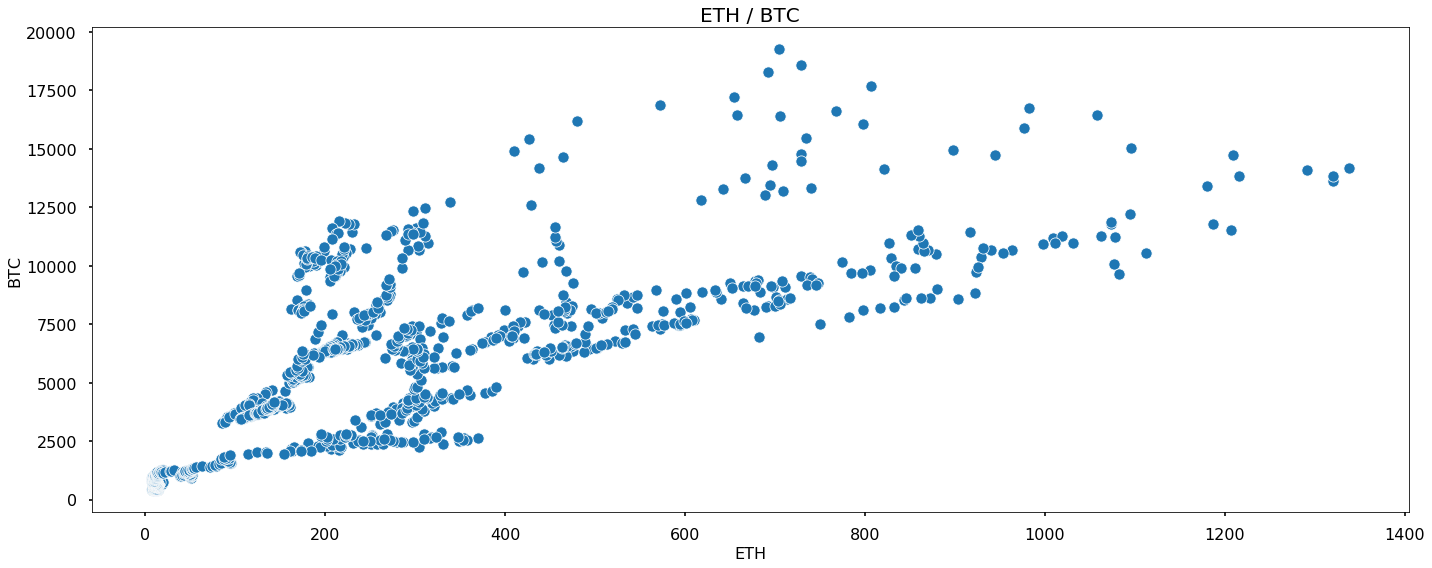

In [3]:
plot_prices(df, 'ETH', 'BTC')

### Dynamical Linear Regression

##### Model

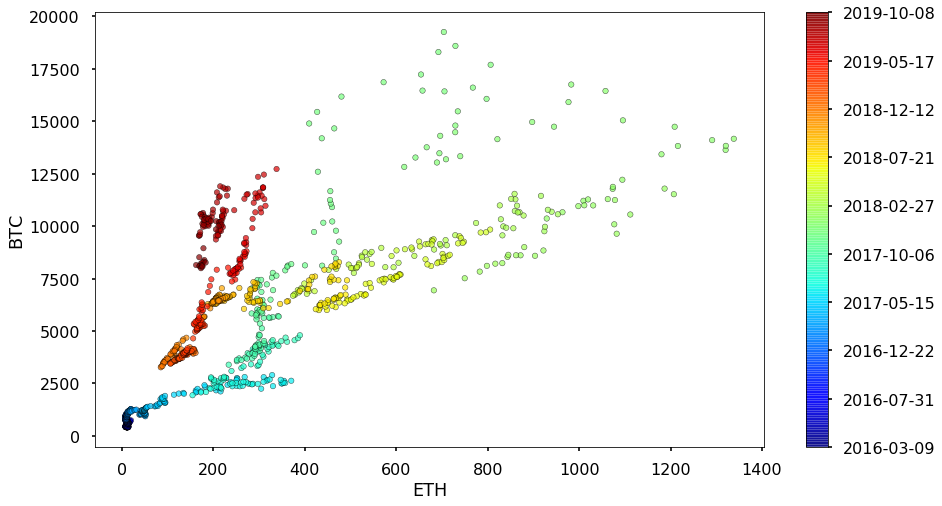

In [4]:
plot_prices_over_time(df)

Lets make define with $b_k$ and $e_k$ the prices of BTC and ETH respectievly at timestep $k$. Underlying assumption is that there is a ***linear relationship*** between these prices:

$$
b_k = \alpha + \beta e_k,
$$

where $\alpha$ and $\beta$ *intercept* and *slope* respectievly. 

We can see that in reality the slope and intercept are changing over time. So we will assume that they are changing with some dynamical model. Say they are doing some random walk. If we denote with $x_k \equiv [\alpha_{k}, \beta_{k}]^T$, then as a dynamical model for slope and intercept we have

$$
x_k = x_{k-1} + N(0, Q_k)
$$

$x_k$ is connected with the prices with the following equation:

$$b_k = [1, e_k]x_k = H_kx_k.$$

With this setup we can use **Kalman filter for estimating slope and intercept using random walk as a dynamical model and observations from the market**.

##### Soloution

Kalman filter 

In [5]:
class KalmanFilter:
    """Implementation of ordinary Kalman filter."""

    def __init__(self,
                 initial_state: np.ndarray,
                 initial_covariance: np.ndarray,
                 transition_matrix: np.ndarray,
                 measurement_matrix: np.ndarray,
                 process_covariance: np.ndarray,
                 measurement_covariance: np.ndarray):

        self.x = initial_state
        self.P = initial_covariance
        
        self.F = transition_matrix
        self.H = measurement_matrix
        
        self.Q = process_covariance
        self.R = measurement_covariance

    def predict(self, transition_matrix: np.ndarray = None) -> np.ndarray:
        if transition_matrix is not None:
            self.F = transition_matrix

        self.x = np.dot(self.F, self.x)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        return self.x.copy()

    def update(self, z: np.ndarray, measurement_matrix: np.ndarray = None):
        if measurement_matrix is not None:
            self.H = measurement_matrix

        # calculating Kalman gain
        y = z - np.dot(self.H, self.x)
        S = self.R + np.dot(self.H, np.dot(self.P, self.H.T))
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))

        # updating state
        self.x = self.x + np.dot(K, y)

        # updating state covariance
        I = np.eye(self.F.shape[1])
        self.P = np.add(
            np.dot(np.dot(I - np.dot(K, self.H), self.P), (I - np.dot(K, self.H)).T),
            np.dot(np.dot(K, self.R), K.T)
        )

In [6]:
kf = KalmanFilter(
    initial_state=np.array([0, 41]), # intercept=0, slope=41
    initial_covariance=np.array([[1, 0], [0, 1]]),
    transition_matrix=np.eye(2),
    measurement_matrix=np.array([[1, 10.65]]), 
    process_covariance=np.array([[1e-7, 0], [0, 1e-6]]), 
    measurement_covariance=np.array([[1]]),
)

In [7]:
intercepts_slopes = []
for btc_price, eth_price in zip(df['BTC'], df['ETH']):
    measurement_matrix = np.array([[1, eth_price]])
    kf.predict()
    kf.update(btc_price, measurement_matrix=measurement_matrix)
    intercepts_slopes.append(kf.x)


intercepts_slopes = pd.DataFrame(
    np.array(intercepts_slopes), 
    columns=['intercept', 'slope'],
    index=df.index
)

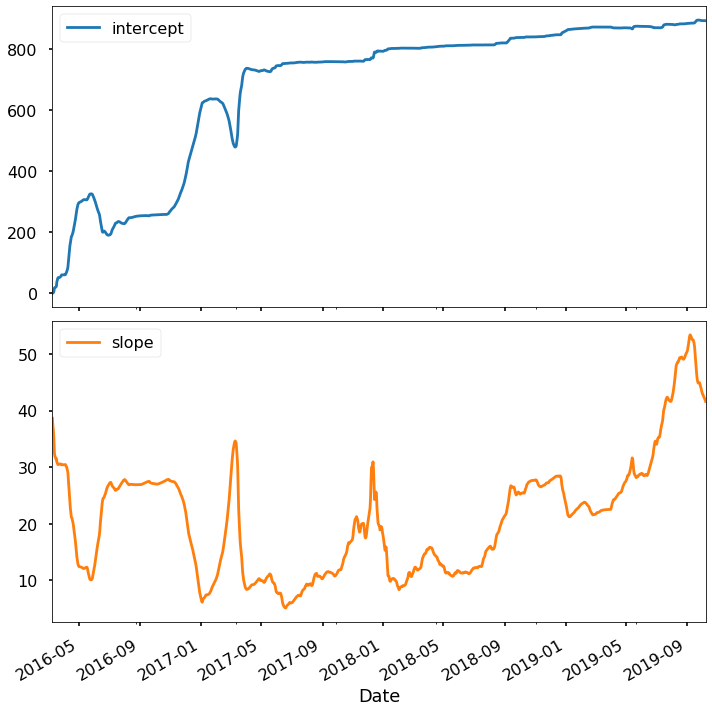

In [8]:
intercepts_slopes.plot(subplots=True, figsize=(10, 10))
plt.tight_layout()

##### Results

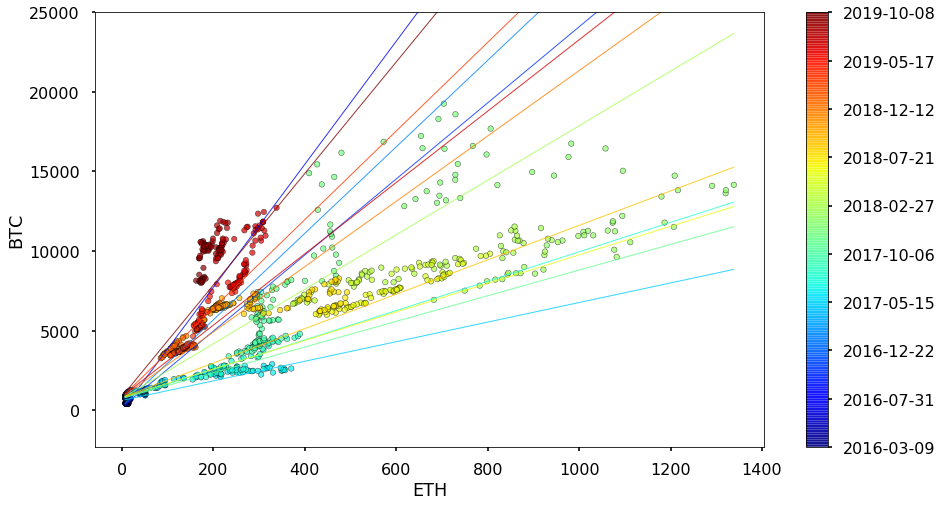

In [9]:
plot_regression_lines(df, intercepts_slopes, step=100)